## **ResNet**
![resnet](https://camo.githubusercontent.com/704b08300591835f9e497fd196411eea0cf17923674a5571cdc2608c5c4d9461/68747470733a2f2f692e696d6775722e636f6d2f784a37534e754c2e706e67)
![resnet](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

### ResNet Block
- Identity Block
![idblock](https://camo.githubusercontent.com/d24b78b504d6d7915e4bc3905bed2cdd4a220d71bd90d29a2afe773866c735e9/68747470733a2f2f692e696d6775722e636f6d2f50535531706e372e706e67)
- Convolutional Block
![convblock](https://camo.githubusercontent.com/328fb949f46a0a45c325e1be57c793c3e615984c56c66b5a1c5d93cc7fbbf2f0/68747470733a2f2f692e696d6775722e636f6d2f484f6c71796c622e706e67)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
keras_resnet_50 = ResNet50(weights='imagenet')
keras_resnet_50.summary()

102981632/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [3]:
def resnet_block(input_layer, filters, kernel_size=3, stride=1, use_residual=True, use_projection=False, block_name="res_block"):
    """Defines a basic ResNet block with optional projection for downsampling."""
    x = input_layer

    # shortcut
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal',
                      name=f'{block_name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{block_name}_bn1')(x)
    x = layers.Activation('relu', name=f'{block_name}_act1')(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal',
                      name=f'{block_name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{block_name}_bn2')(x)

    # Apply projection if needed
    if use_projection and use_residual:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal',
                                 name=f'{block_name}_short')(shortcut)
        shortcut = layers.BatchNormalization(name=f'{block_name}_short_bn')(shortcut)

    # Add residual connection
    if use_residual:
        x = layers.Add(name=f'{block_name}_add')([x, shortcut])
    x = layers.Activation('relu', name=f'{block_name}_act2')(x)

    return x

In [4]:
def resnet_bottleneck_block(input_layer, filters, stride=1, use_residual=True, use_projection=False, block_name="res_bottleneck_block"):
    """Defines a ResNet bottleneck block with optional projection for downsampling."""
    x = input_layer

    # Shortcut path
    shortcut = x

    # 1x1 conv (reduce channels)
    x = layers.Conv2D(filters // 4, kernel_size=1, strides=1, padding='same', name=f'{block_name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{block_name}_bn1')(x)
    x = layers.Activation('relu', name=f'{block_name}_act1')(x)

    # 3x3 conv (process features)
    x = layers.Conv2D(filters // 4, kernel_size=3, strides=stride, padding='same', name=f'{block_name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{block_name}_bn2')(x)
    x = layers.Activation('relu', name=f'{block_name}_act2')(x)

    # 1x1 conv (restore channels)
    x = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', name=f'{block_name}_conv3')(x)
    x = layers.BatchNormalization(name=f'{block_name}_bn3')(x)

    # Apply projection if needed
    if use_projection and use_residual:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', name=f'{block_name}_short')(shortcut)
        shortcut = layers.BatchNormalization(name=f'{block_name}_short_bn')(shortcut)

    # Add residual connection
    if use_residual:
        x = layers.Add(name=f'{block_name}_add')([x, shortcut])
    x = layers.Activation('relu', name=f'{block_name}_act3')(x)

    return x


In [5]:
def build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False, use_residual=True, initial_filters=64, model_name="resnet"):
    """Builds a ResNet model based on given block configurations."""
    block_config = [3, 4, 6, 3] if not is_50 else [3, 4, 6, 3]

    input_layer = keras.Input(shape=input_shape, name='input_layer')

    output_layer = layers.ZeroPadding2D((3, 3), name='zero_pad')(input_layer)

    output_layer = layers.Conv2D(initial_filters, 7, strides=2, padding='valid', kernel_initializer='he_normal', name='conv1')(output_layer)
    output_layer = layers.BatchNormalization(name='bn1')(output_layer)
    output_layer = layers.Activation('relu', name='act1')(output_layer)
    output_layer = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='maxpool')(output_layer)

    filters = initial_filters
    for stage, num_blocks in enumerate(block_config):
        for block in range(num_blocks):
            stride = 2 if block == 0 and stage != 0 else 1
            use_projection = (block == 0 and stage != 0)
            if is_50:
                # Use Bottleneck for ResNet-50 or more
                output_layer = resnet_bottleneck_block(output_layer, filters, stride=stride, use_residual=use_residual, use_projection=use_projection, block_name=f'stage{stage+2}_{block+1}')
            else:
                # Use Basic Block for ResNet-34
                output_layer = resnet_block(output_layer, filters, stride=stride, use_residual=use_residual, use_projection=use_projection, block_name=f'stage{stage+2}_{block+1}')
        # Double filters at each stage
        filters *= 2

    output_layer = layers.GlobalAveragePooling2D(name='avg_pool')(output_layer)
    output_layer = layers.Dense(num_classes, activation='softmax', name='fc')(output_layer)

    model = keras.Model(inputs=input_layer, outputs=output_layer, name=model_name)
    return model

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# commentout only if using lms
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# Load the data
(train_data, validation_data, test_data), info = tfds.load('cats_vs_dogs',
                                                           split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                           with_info=True,
                                                           as_supervised=True)
# Get the labels for the images
label_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'label names : {label_names}, num_classes : {num_classes}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
label names : ['cat', 'dog'], num_classes : 2


In [8]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    t

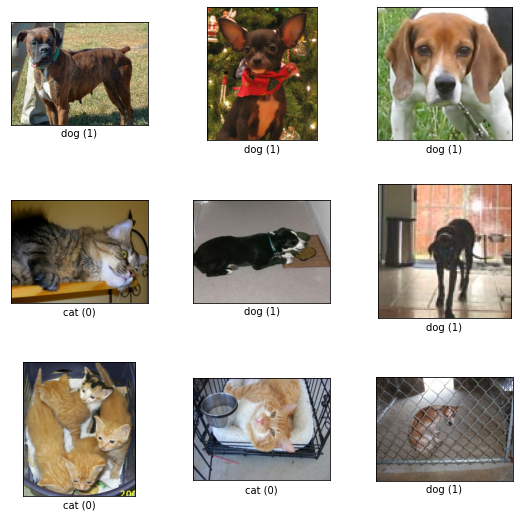

In [9]:
fig = tfds.show_examples(train_data, info)

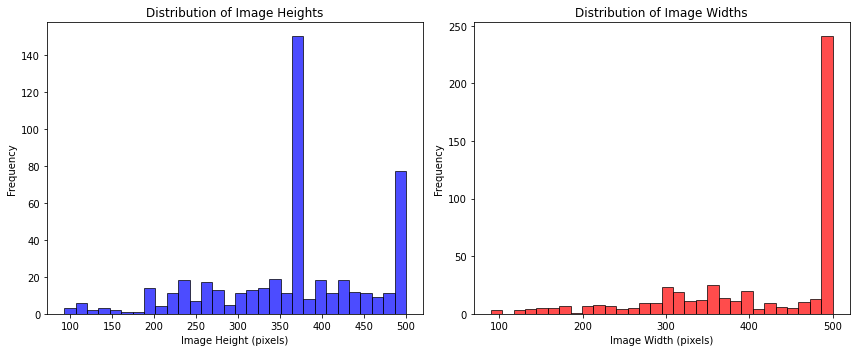

(366.484, 410.334)

In [10]:
import numpy as np

def get_image_sizes(dataset, num_samples=500):
    sizes = []
    for image, _ in dataset.take(num_samples):
        sizes.append(image.shape[:2])
    return np.array(sizes)

# Get image sizes for 500 samples
image_sizes = get_image_sizes(train_data, num_samples=500)

# Extract height and width separately
heights, widths = image_sizes[:, 0], image_sizes[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Image Height (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Heights")

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, alpha=0.7, color='r', edgecolor='black')
plt.xlabel("Image Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Widths")

plt.tight_layout()
plt.show()

avg_height, avg_width = np.mean(heights), np.mean(widths)
avg_height, avg_width

In [11]:
IMAGE_SIZE=32
BATCH_SIZE=256
EPOCHS=30

In [12]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return tf.cast(image, tf.float32) / 255., label

In [13]:
train_data = train_data.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
validation_data = validation_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


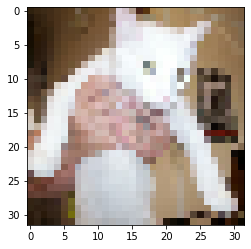

In [14]:
import matplotlib.pyplot as plt

image, label = next(iter(train_data))

plt.imshow(image[0])
plt.show()

In [15]:
# Build ResNet-34
resnet_34 = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=num_classes, is_50=False)
resnet_34.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_pad (ZeroPadding2D)        (None, 38, 38, 3)    0           input_layer[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_pad[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 16, 16, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [16]:
plain_cnn_34 = build_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=num_classes, is_50=True, use_residual=False)
plain_cnn_34.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_pad (ZeroPadding2D)     (None, 38, 38, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
act1 (Activation)            (None, 16, 16, 64)        0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 16)          1040 

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [19]:
resnet_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history_resnet34 = resnet_34.fit(train_data, validation_data=validation_data, epochs=EPOCHS, callbacks=[early_stopping])
history_resnet34 = resnet_34.fit(train_data, validation_data=validation_data, epochs=EPOCHS)

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 37s 102ms/step - loss: 0.8212 - accuracy: 0.6009 - val_loss: 7.9761 - val_accuracy: 0.5185
Epoch 2/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7058

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.5704 - accuracy: 0.7058 - val_loss: 0.7195 - val_accuracy: 0.5434
Epoch 3/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7581

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 79ms/step - loss: 0.4977 - accuracy: 0.7581 - val_loss: 0.6100 - val_accuracy: 0.6621
Epoch 4/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 79ms/step - loss: 0.4310 - accuracy: 0.8030 - val_loss: 0.7067 - val_accuracy: 0.6535
Epoch 5/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8395

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.3568 - accuracy: 0.8395 - val_loss: 0.8538 - val_accuracy: 0.6156
Epoch 6/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8649

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.3117 - accuracy: 0.8649 - val_loss: 1.2737 - val_accuracy: 0.5795
Epoch 7/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.8987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.2438 - accuracy: 0.8987 - val_loss: 0.8147 - val_accuracy: 0.6831
Epoch 8/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9095

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 79ms/step - loss: 0.2197 - accuracy: 0.9095 - val_loss: 1.1629 - val_accuracy: 0.5864
Epoch 9/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9329

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.1716 - accuracy: 0.9329 - val_loss: 1.0224 - val_accuracy: 0.7072
Epoch 10/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9413

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.1489 - accuracy: 0.9413 - val_loss: 0.9720 - val_accuracy: 0.6892
Epoch 11/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9530

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.1236 - accuracy: 0.9530 - val_loss: 1.0576 - val_accuracy: 0.7180
Epoch 12/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.1146 - accuracy: 0.9545 - val_loss: 1.0153 - val_accuracy: 0.7137
Epoch 13/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9615

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.0993 - accuracy: 0.9615 - val_loss: 1.1185 - val_accuracy: 0.7115
Epoch 14/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9645

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.0952 - accuracy: 0.9645 - val_loss: 1.0055 - val_accuracy: 0.7094
Epoch 15/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9704

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.0794 - accuracy: 0.9704 - val_loss: 1.2263 - val_accuracy: 0.7089
Epoch 16/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.0748 - accuracy: 0.9720 - val_loss: 1.1581 - val_accuracy: 0.6978
Epoch 17/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9753

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0676 - accuracy: 0.9753 - val_loss: 1.4750 - val_accuracy: 0.6887
Epoch 18/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 15s 81ms/step - loss: 0.0673 - accuracy: 0.9750 - val_loss: 1.2582 - val_accuracy: 0.7098
Epoch 19/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9793

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0580 - accuracy: 0.9793 - val_loss: 1.2270 - val_accuracy: 0.7150
Epoch 20/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9752

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 80ms/step - loss: 0.0673 - accuracy: 0.9752 - val_loss: 1.3799 - val_accuracy: 0.7094
Epoch 21/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9792

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 1.7489 - val_accuracy: 0.6995
Epoch 22/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9803

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0517 - accuracy: 0.9803 - val_loss: 1.4434 - val_accuracy: 0.6900
Epoch 23/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0483 - accuracy: 0.9811 - val_loss: 1.2774 - val_accuracy: 0.7343
Epoch 24/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9837

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0461 - accuracy: 0.9837 - val_loss: 1.2238 - val_accuracy: 0.7339
Epoch 25/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0419 - accuracy: 0.9852 - val_loss: 1.2015 - val_accuracy: 0.7184
Epoch 26/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 15s 81ms/step - loss: 0.0505 - accuracy: 0.9817 - val_loss: 1.4007 - val_accuracy: 0.7111
Epoch 27/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9819

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0471 - accuracy: 0.9819 - val_loss: 1.2821 - val_accuracy: 0.7322
Epoch 28/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0308 - accuracy: 0.9896 - val_loss: 1.4718 - val_accuracy: 0.7304
Epoch 29/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 81ms/step - loss: 0.0421 - accuracy: 0.9852 - val_loss: 1.4618 - val_accuracy: 0.6982
Epoch 30/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9844

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 14s 82ms/step - loss: 0.0409 - accuracy: 0.9844 - val_loss: 1.2980 - val_accuracy: 0.7132


In [20]:
def visualize_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

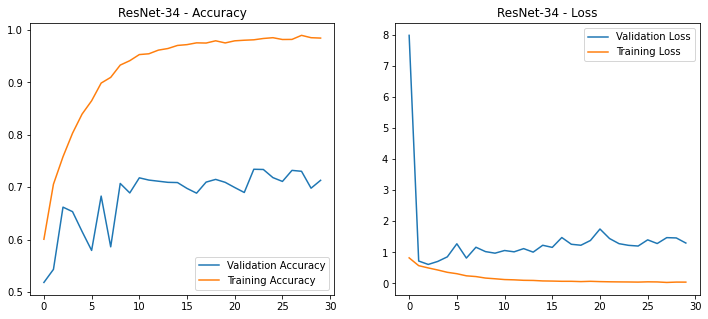

In [21]:
visualize_history(history_resnet34, "ResNet-34")

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.7475 - accuracy: 0.5062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 19s 71ms/step - loss: 0.7468 - accuracy: 0.5066 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 2/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:24 - loss: 0.6944 - accuracy: 0.5117

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.4996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.7016 - accuracy: 0.4996 - val_loss: 0.6934 - val_accuracy: 0.5185
Epoch 3/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.6909 - accuracy: 0.5562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.5069

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6968 - accuracy: 0.5069 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 4/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.6935 - accuracy: 0.5156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.6959 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 5/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:13 - loss: 0.6927 - accuracy: 0.5273

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.6967 - accuracy: 0.5075 - val_loss: 0.7003 - val_accuracy: 0.4815
Epoch 6/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.6998 - accuracy: 0.4922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.5070

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6978 - accuracy: 0.5070 - val_loss: 0.6937 - val_accuracy: 0.4819
Epoch 7/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:13 - loss: 0.6998 - accuracy: 0.4805

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.7059 - accuracy: 0.5046 - val_loss: 0.6966 - val_accuracy: 0.5206
Epoch 8/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.6949 - accuracy: 0.4382

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5013

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 48ms/step - loss: 0.6950 - accuracy: 0.5013 - val_loss: 0.6923 - val_accuracy: 0.5249
Epoch 9/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:26 - loss: 0.6993 - accuracy: 0.5156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5061

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6961 - accuracy: 0.5061 - val_loss: 0.6946 - val_accuracy: 0.5249
Epoch 10/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:13 - loss: 0.6951 - accuracy: 0.5195

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5131

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6970 - accuracy: 0.5131 - val_loss: 0.6949 - val_accuracy: 0.4798
Epoch 11/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5023

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6961 - accuracy: 0.5023 - val_loss: 0.7050 - val_accuracy: 0.5267
Epoch 12/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:24 - loss: 0.6996 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5049

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6941 - accuracy: 0.5053 - val_loss: 0.6930 - val_accuracy: 0.4824
Epoch 13/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:28 - loss: 0.6961 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5085

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6928 - accuracy: 0.5085 - val_loss: 0.7006 - val_accuracy: 0.5245
Epoch 14/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:27 - loss: 0.6979 - accuracy: 0.5391

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6964 - val_accuracy: 0.5211
Epoch 15/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:13 - loss: 0.6817 - accuracy: 0.5352

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6912 - accuracy: 0.5032

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.6912 - accuracy: 0.5028 - val_loss: 0.7003 - val_accuracy: 0.5249
Epoch 16/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.7071 - accuracy: 0.5430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5100

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6904 - accuracy: 0.5100 - val_loss: 0.6971 - val_accuracy: 0.5202
Epoch 17/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:27 - loss: 0.6955 - accuracy: 0.5078

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5070

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6893 - accuracy: 0.5068 - val_loss: 0.6927 - val_accuracy: 0.5245
Epoch 18/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.7085 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5044

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6910 - accuracy: 0.5044 - val_loss: 0.7107 - val_accuracy: 0.5185
Epoch 19/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:27 - loss: 0.7099 - accuracy: 0.4727

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5094

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6925 - accuracy: 0.5094 - val_loss: 0.6980 - val_accuracy: 0.4781
Epoch 20/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5136

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6908 - accuracy: 0.5136 - val_loss: 0.6933 - val_accuracy: 0.5224
Epoch 21/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.6787 - accuracy: 0.5195

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5049

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6926 - accuracy: 0.5049 - val_loss: 0.7095 - val_accuracy: 0.5236
Epoch 22/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:29 - loss: 0.6912 - accuracy: 0.5078

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6882 - accuracy: 0.5083 - val_loss: 0.7035 - val_accuracy: 0.5245
Epoch 23/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.6857 - accuracy: 0.5078

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5136

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.6910 - accuracy: 0.5136 - val_loss: 0.7006 - val_accuracy: 0.5228
Epoch 24/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:26 - loss: 0.6830 - accuracy: 0.5195

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.6905 - accuracy: 0.5136 - val_loss: 0.7231 - val_accuracy: 0.5236
Epoch 25/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:11 - loss: 0.6919 - accuracy: 0.5078

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5110

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6842 - accuracy: 0.5106 - val_loss: 0.7021 - val_accuracy: 0.5241
Epoch 26/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:34 - loss: 0.6808 - accuracy: 0.5273

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.5189

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6815 - accuracy: 0.5189 - val_loss: 0.7062 - val_accuracy: 0.5206
Epoch 27/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.6775 - accuracy: 0.5195

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5136

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6843 - accuracy: 0.5136 - val_loss: 0.7484 - val_accuracy: 0.5219
Epoch 28/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:06 - loss: 0.6834 - accuracy: 0.5078

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5151

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6836 - accuracy: 0.5151 - val_loss: 0.7316 - val_accuracy: 0.5232
Epoch 29/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5189

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6851 - accuracy: 0.5189 - val_loss: 0.7008 - val_accuracy: 0.4807
Epoch 30/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5218

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6794 - accuracy: 0.5218 - val_loss: 0.7103 - val_accuracy: 0.5232


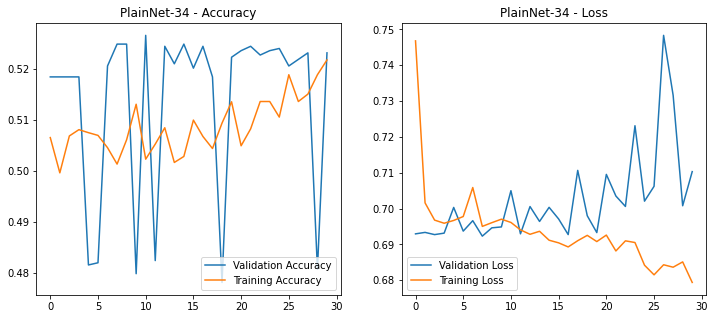

In [22]:
plain_cnn_34.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history_plain_cnn_34 = plain_cnn_34.fit(train_data, validation_data=validation_data, epochs=EPOCHS, callbacks=[early_stopping])
history_plain_cnn_34 = plain_cnn_34.fit(train_data, validation_data=validation_data, epochs=EPOCHS)
visualize_history(history_plain_cnn_34, "PlainNet-34")

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict(image_path, ds_info, model, debug=False):
    test_image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # preprocess
    test_image = tf.image.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
    test_image = tf.cast(test_image, tf.float32) / 255.
    if debug:
        plt.imshow(test_image)
        plt.show()
    
    # reshape to adjust the batch dimension
    test_image = tf.expand_dims(test_image, axis=0)
    
    # predict
    output = model.predict(test_image)
    
    label_index = np.argmax(output)
    label = ds_info.features['label'].int2str(label_index)

    return label_index, label

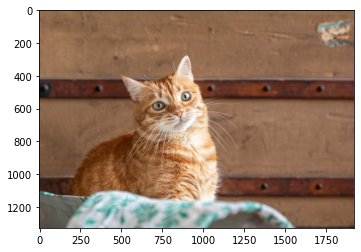

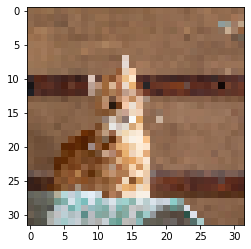

ResNet-34 prediction : (1, 'dog'), Actual label : Cat


In [43]:
test_image_path = os.getenv('HOME')+"/aiffel/cv/resnet/data/cat.jpg"
res_label_idx, res_label = predict(test_image_path, info, resnet_34, debug=True)
print(f'ResNet-34 prediction : {res_label_idx, res_label}, Actual label : Cat')

In [29]:
plain_label_idx, plain_label = predict(test_image_path, info, plain_cnn_34)
print(f'PlainNet-34 prediction : {plain_label_idx, plain_label}, Actual label : Cat')

PlainNet-34 prediction : (1, 'dog'), Actual label : Cat


In [30]:
resnet_50 = build_resnet(input_shape=(32, 32,3), num_classes=2, is_50=True)
resnet_50.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_pad (ZeroPadding2D)        (None, 38, 38, 3)    0           input_layer[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_pad[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 16, 16, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 15:47 - loss: 1.2739 - accuracy: 0.5273

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.5206

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 18s 63ms/step - loss: 0.8778 - accuracy: 0.5206 - val_loss: 0.6916 - val_accuracy: 0.5249
Epoch 2/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.7705 - accuracy: 0.4883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.7053 - accuracy: 0.5730

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.7044 - accuracy: 0.5734 - val_loss: 0.6876 - val_accuracy: 0.5387
Epoch 3/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.6719 - accuracy: 0.5977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.6358

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.6406 - accuracy: 0.6358 - val_loss: 0.6778 - val_accuracy: 0.5748
Epoch 4/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.5127 - accuracy: 0.7734

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.6927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 56ms/step - loss: 0.5874 - accuracy: 0.6927 - val_loss: 0.6662 - val_accuracy: 0.5847
Epoch 5/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.5045 - accuracy: 0.7656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.5439 - accuracy: 0.7257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.5447 - accuracy: 0.7251 - val_loss: 0.7354 - val_accuracy: 0.5727
Epoch 6/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:11 - loss: 0.4565 - accuracy: 0.7930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7401

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.5190 - accuracy: 0.7401 - val_loss: 0.7115 - val_accuracy: 0.6045
Epoch 7/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.4810 - accuracy: 0.7617

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.7696

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.4790 - accuracy: 0.7696 - val_loss: 0.7772 - val_accuracy: 0.5993
Epoch 8/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.4564 - accuracy: 0.7812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.7907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.4458 - accuracy: 0.7907 - val_loss: 0.7633 - val_accuracy: 0.6040
Epoch 9/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:11 - loss: 0.4083 - accuracy: 0.8086

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.4149 - accuracy: 0.8093

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.4155 - accuracy: 0.8089 - val_loss: 0.9887 - val_accuracy: 0.6019
Epoch 10/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.3920 - accuracy: 0.8241 - val_loss: 0.8357 - val_accuracy: 0.6187
Epoch 11/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:37 - loss: 0.2586 - accuracy: 0.8984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8370

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 53ms/step - loss: 0.3668 - accuracy: 0.8370 - val_loss: 1.0606 - val_accuracy: 0.5778
Epoch 12/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:46 - loss: 0.3777 - accuracy: 0.8242

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8572

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 53ms/step - loss: 0.3311 - accuracy: 0.8572 - val_loss: 0.9414 - val_accuracy: 0.6006
Epoch 13/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:15 - loss: 0.2863 - accuracy: 0.8711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8585

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.3221 - accuracy: 0.8577 - val_loss: 0.9328 - val_accuracy: 0.6152
Epoch 14/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:24 - loss: 0.2460 - accuracy: 0.8828

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8791

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.2858 - accuracy: 0.8791 - val_loss: 0.9471 - val_accuracy: 0.6277
Epoch 15/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.1678 - accuracy: 0.9414

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.8904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.2663 - accuracy: 0.8904 - val_loss: 1.0412 - val_accuracy: 0.6131
Epoch 16/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:17 - loss: 0.2652 - accuracy: 0.9062

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.2500 - accuracy: 0.8962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.2507 - accuracy: 0.8959 - val_loss: 1.1279 - val_accuracy: 0.6036
Epoch 17/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:35 - loss: 0.2280 - accuracy: 0.8945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9041

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 54ms/step - loss: 0.2293 - accuracy: 0.9040 - val_loss: 1.2476 - val_accuracy: 0.5954
Epoch 18/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.1033 - accuracy: 0.9766

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9123

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.2159 - accuracy: 0.9123 - val_loss: 1.0553 - val_accuracy: 0.6380
Epoch 19/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9208

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.2049 - accuracy: 0.9208 - val_loss: 1.1275 - val_accuracy: 0.6221
Epoch 20/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:16 - loss: 0.0810 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9248

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.1928 - accuracy: 0.9248 - val_loss: 1.0632 - val_accuracy: 0.6410
Epoch 21/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.1092 - accuracy: 0.9648

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9345

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.1675 - accuracy: 0.9345 - val_loss: 1.4179 - val_accuracy: 0.6238
Epoch 22/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9348

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.1675 - accuracy: 0.9348 - val_loss: 1.2778 - val_accuracy: 0.6242
Epoch 23/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:41 - loss: 0.1496 - accuracy: 0.9258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9434

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 54ms/step - loss: 0.1452 - accuracy: 0.9434 - val_loss: 1.1441 - val_accuracy: 0.6445
Epoch 24/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.0464 - accuracy: 0.9883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9413

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.1514 - accuracy: 0.9409 - val_loss: 1.3741 - val_accuracy: 0.6337
Epoch 25/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.1502 - accuracy: 0.9570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9451

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.1473 - accuracy: 0.9442 - val_loss: 1.3342 - val_accuracy: 0.6139
Epoch 26/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.1357 - accuracy: 0.9492

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9423

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.1463 - accuracy: 0.9423 - val_loss: 1.1963 - val_accuracy: 0.6384
Epoch 27/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9493

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 52ms/step - loss: 0.1290 - accuracy: 0.9493 - val_loss: 1.5228 - val_accuracy: 0.6247
Epoch 28/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.0609 - accuracy: 0.9766

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.1252 - accuracy: 0.9521 - val_loss: 1.2711 - val_accuracy: 0.6230
Epoch 29/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.0595 - accuracy: 0.9766

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9532

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 53ms/step - loss: 0.1209 - accuracy: 0.9532 - val_loss: 1.2715 - val_accuracy: 0.6367
Epoch 30/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:41 - loss: 0.1267 - accuracy: 0.9570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9554

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 54ms/step - loss: 0.1203 - accuracy: 0.9554 - val_loss: 1.3867 - val_accuracy: 0.6217


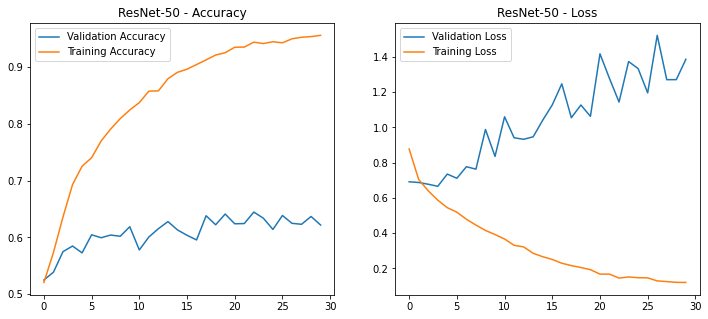

In [31]:
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history_resnet50 = resnet_50.fit(train_data, validation_data=validation_data, epochs=EPOCHS, callbacks=[early_stopping])
history_resnet50 = resnet_50.fit(train_data, validation_data=validation_data, epochs=EPOCHS)
visualize_history(history_resnet50, "ResNet-50")

In [32]:
plain_cnn_50 = build_resnet(input_shape=(32, 32, 3), num_classes=2, is_50=True, use_residual=False)
plain_cnn_50.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_pad (ZeroPadding2D)     (None, 38, 38, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
act1 (Activation)            (None, 16, 16, 64)        0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 16)          1040 

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 14:51 - loss: 0.8740 - accuracy: 0.4727

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.5079

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 17s 60ms/step - loss: 0.7240 - accuracy: 0.5079 - val_loss: 0.6971 - val_accuracy: 0.5185
Epoch 2/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:14 - loss: 0.6742 - accuracy: 0.5586

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6970 - accuracy: 0.5089

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.6969 - accuracy: 0.5092 - val_loss: 0.6974 - val_accuracy: 0.5185
Epoch 3/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:13 - loss: 0.6838 - accuracy: 0.5000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5148

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 54ms/step - loss: 0.6915 - accuracy: 0.5148 - val_loss: 0.6946 - val_accuracy: 0.5185
Epoch 4/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:39 - loss: 0.6868 - accuracy: 0.5469

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5303

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 51ms/step - loss: 0.6843 - accuracy: 0.5303 - val_loss: 0.6940 - val_accuracy: 0.5185
Epoch 5/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:42 - loss: 0.6788 - accuracy: 0.5156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5324

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 51ms/step - loss: 0.6832 - accuracy: 0.5329 - val_loss: 0.6964 - val_accuracy: 0.5215
Epoch 6/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:11 - loss: 0.6719 - accuracy: 0.5508

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.5506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6776 - accuracy: 0.5506 - val_loss: 0.6971 - val_accuracy: 0.5228
Epoch 7/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:07 - loss: 0.6754 - accuracy: 0.5859

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5696

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6742 - accuracy: 0.5696 - val_loss: 0.6926 - val_accuracy: 0.5353
Epoch 8/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:04 - loss: 0.6419 - accuracy: 0.6055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.5871

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.6670 - accuracy: 0.5874 - val_loss: 0.6830 - val_accuracy: 0.5628
Epoch 9/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.6070

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6569 - accuracy: 0.6070 - val_loss: 0.6825 - val_accuracy: 0.5602
Epoch 10/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6230

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.6471 - accuracy: 0.6230 - val_loss: 0.6872 - val_accuracy: 0.5533
Epoch 11/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.5917 - accuracy: 0.7070

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.6316

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.6392 - accuracy: 0.6316 - val_loss: 0.6961 - val_accuracy: 0.5477
Epoch 12/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.6202 - accuracy: 0.6562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.6520

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.6233 - accuracy: 0.6520 - val_loss: 0.7257 - val_accuracy: 0.5585
Epoch 13/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:38 - loss: 0.6290 - accuracy: 0.6562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6595

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 52ms/step - loss: 0.6173 - accuracy: 0.6595 - val_loss: 0.7123 - val_accuracy: 0.5426
Epoch 14/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:47 - loss: 0.6170 - accuracy: 0.6680

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.6718

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 51ms/step - loss: 0.6043 - accuracy: 0.6718 - val_loss: 0.7123 - val_accuracy: 0.5744
Epoch 15/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:15 - loss: 0.5486 - accuracy: 0.6992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.6795

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.5971 - accuracy: 0.6795 - val_loss: 0.7429 - val_accuracy: 0.5679
Epoch 16/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.5791 - accuracy: 0.7148

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.6854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.5941 - accuracy: 0.6854 - val_loss: 0.7191 - val_accuracy: 0.5666
Epoch 17/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:07 - loss: 0.5727 - accuracy: 0.6953

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.6902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.5887 - accuracy: 0.6902 - val_loss: 0.7313 - val_accuracy: 0.5675
Epoch 18/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.5660 - accuracy: 0.7422

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.5682 - accuracy: 0.7073 - val_loss: 0.7687 - val_accuracy: 0.5843
Epoch 19/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:44 - loss: 0.5330 - accuracy: 0.7305

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.7090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 49ms/step - loss: 0.5652 - accuracy: 0.7084 - val_loss: 0.7996 - val_accuracy: 0.5322
Epoch 20/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:09 - loss: 0.5075 - accuracy: 0.7695

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7210

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.5485 - accuracy: 0.7210 - val_loss: 0.8042 - val_accuracy: 0.5757
Epoch 21/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:04 - loss: 0.5211 - accuracy: 0.7422

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7264

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.5412 - accuracy: 0.7264 - val_loss: 0.7776 - val_accuracy: 0.5653
Epoch 22/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:06 - loss: 0.5248 - accuracy: 0.7188

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.7364

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 51ms/step - loss: 0.5288 - accuracy: 0.7370 - val_loss: 0.7879 - val_accuracy: 0.5860
Epoch 23/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:08 - loss: 0.4854 - accuracy: 0.7656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7414

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.5154 - accuracy: 0.7414 - val_loss: 0.7727 - val_accuracy: 0.5817
Epoch 24/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:47 - loss: 0.5251 - accuracy: 0.7148

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7450

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 13s 50ms/step - loss: 0.5182 - accuracy: 0.7450 - val_loss: 0.9195 - val_accuracy: 0.5714
Epoch 25/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:07 - loss: 0.4149 - accuracy: 0.8281

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.7457

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.5104 - accuracy: 0.7457 - val_loss: 0.8098 - val_accuracy: 0.5911
Epoch 26/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:05 - loss: 0.4451 - accuracy: 0.8086

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.7691

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.4823 - accuracy: 0.7691 - val_loss: 0.8398 - val_accuracy: 0.5761
Epoch 27/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:10 - loss: 0.5336 - accuracy: 0.7266

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/73 [============================>.] - ETA: 0s - loss: 0.4828 - accuracy: 0.7678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 50ms/step - loss: 0.4828 - accuracy: 0.7676 - val_loss: 0.9778 - val_accuracy: 0.5920
Epoch 28/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.4186 - accuracy: 0.8164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.7601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 48ms/step - loss: 0.4874 - accuracy: 0.7601 - val_loss: 0.8823 - val_accuracy: 0.5813
Epoch 29/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.5233 - accuracy: 0.7227

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7740

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.4756 - accuracy: 0.7740 - val_loss: 0.9511 - val_accuracy: 0.5744
Epoch 30/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 1/73 [..............................] - ETA: 10:12 - loss: 0.4631 - accuracy: 0.7695

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


73/73 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.7776

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


73/73 [==============================] - 12s 49ms/step - loss: 0.4640 - accuracy: 0.7776 - val_loss: 0.9934 - val_accuracy: 0.5636


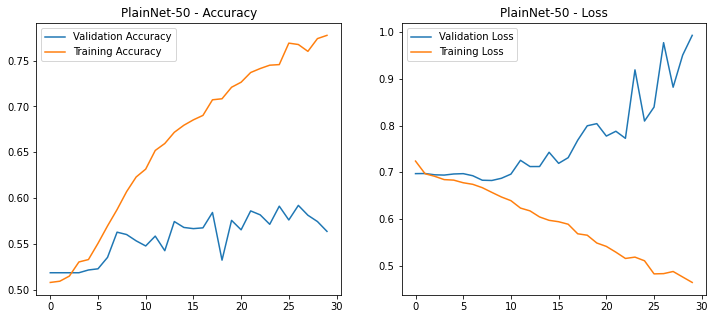

In [33]:
plain_cnn_50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history_plain_cnn_50 = plain_cnn_50.fit(train_data, validation_data=validation_data, epochs=EPOCHS, callbacks=[early_stopping])
history_plain_cnn_50 = plain_cnn_50.fit(train_data, validation_data=validation_data, epochs=EPOCHS)
visualize_history(history_plain_cnn_50, "PlainNet-50")

In [44]:
res_50_label_idx, res_50_label = predict(test_image_path, info, resnet_50)
print(f'ResNet-50 prediction : {res_50_label_idx, res_50_label}, Actual label : Cat')

plain_50_label_idx, plain_50_label = predict(test_image_path, info, plain_cnn_50)
print(f'PlainNet-34 prediction : {plain_label_idx, plain_label}, Actual label : Cat')

ResNet-50 prediction : (0, 'cat'), Actual label : Cat
PlainNet-34 prediction : (1, 'dog'), Actual label : Cat


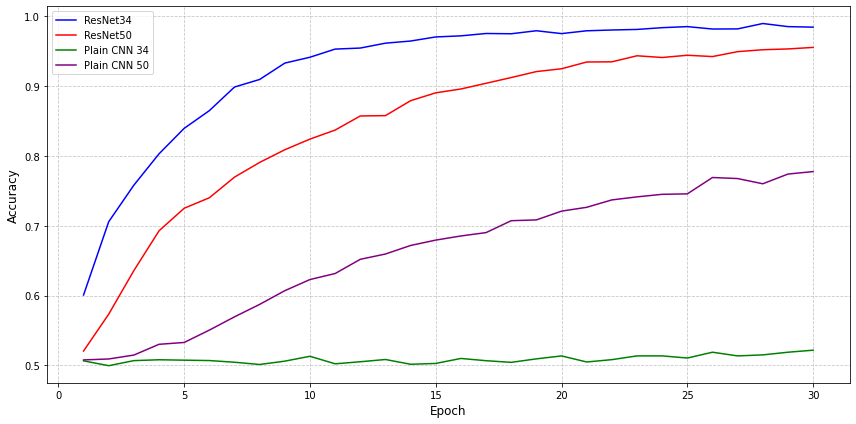

In [41]:
histories = [history_resnet34, history_resnet50, history_plain_cnn_34, history_plain_cnn_50]
models = ['ResNet34', 'ResNet50', 'Plain CNN 34', 'Plain CNN 50']
colors = ['blue', 'red', 'green', 'purple']

plt.figure(figsize=(12, 6))

for i, (model_name, history) in enumerate(zip(models, histories)):
    accuracy = []
    accuracy = history.history.get('accuracy', history.history.get('acc', []))
    
    if len(accuracy) > 0:
        epochs = range(1, len(accuracy) + 1)
        plt.plot(epochs, accuracy, color=colors[i], label=f'{model_name}')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [42]:
import pandas as pd

data = {}

for model_name, history in zip(models, histories):
    data[model_name] = history.history.get('accuracy', history.history.get('acc', []))

df = pd.DataFrame(data)
df.index.name = 'Epoch'
df.index = df.index + 1

df

,ResNet34,ResNet50,Plain CNN 34,Plain CNN 50
Epoch,,,,
1,0.600860,0.520634,0.506556,0.507899
2,0.705803,0.573401,0.499624,0.509242
3,0.758141,0.635841,0.506878,0.514831
4,0.803009,0.692746,0.508114,0.530253
5,0.839495,0.725094,0.507523,0.532886
6,0.864858,0.740086,0.506985,0.550564
7,0.898657,0.769640,0.504567,0.569586
8,0.909511,0.790704,0.501343,0.587426
9,0.932939,0.808866,0.506126,0.607039


## 회고
- ResNet-50만 prediction 성공 ㅠ_ㅠ
```
ResNet-50 prediction : (0, 'cat'), Actual label : Cat
```

### ResNet 구현
- 노드에 나온 모델의 `summary`와 Keras ResNet-50 모델의 `summary` 비교
  1. `ZeroPadding2D` 레이어의 유무
      - 케라스 모델에서는 입력 레이어 다음에 패딩 레이어가 위치
      - 하지만 노드에서는 없음
      - 그렇다면 크기를 맞춰주기 위해서 convolution layer의 크기와 패딩의 유무가 서로 다를 것으로 예상됨
  2. `GlobalAveragePooling2D` 레이어의 유무
      - 케라스 모델에서는 `GlobalAveragePooling2D` 레이어를 사용
      - 노드 모델에서는 `AveragePooling2D`와 `Flatten` 레이어를 사용 (ResNet-50에는 빠져있음..)
      - `GlobalAveragePooling2D`를 통해 flatten 효과를 줄 수 있고 입력 크기에 대해 좀 더 자유로울 수 있음


### 학습을 방해하는 요소
#### 1. 노드 상에서는 케라스 버전 문제로 dataset을 4.0.0 버전을 사용
```
# commentout only if using lms
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
```
- colab에서는 4.0.1 버전 사용 가능
- 해당 데이터 셋 버전을 하기 에러를 야기함
    ```
    Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
    ```
    - 원인 : 데이터 셋 내부에 깨진 이미지 파일이 존재함
    - 시도 가능한 해결 방법 : 깨진 이미지를 삭제 (ㅎㅎ 시간 관계 상 시도하지는 않음..!!)
    - 참고 : https://github.com/tensorflow/datasets/issues/2188

#### 2. 이미지 화질
![dataset_avg_size.png](./images/dataset_avg_size.png)
- 이미지의 평균 가로, 세로 길이는 각 410, 366 픽셀 정도..
![reshaped_image.png](./images/reshaped_image.png)
- 하지만 구현을 위해 32 픽셀의 정사각형으로 바꿈
- 모델은 이런 모자이크 이미지를 알아볼 수 있을까..? ㅠ
